# Snow Burial Bug Fix analysis

Snow burial is currently coded so that at a snow depth of 20 cm, crops and grasses are fully buried. Issue #516 is described here: https://github.com/ESCOMP/CTSM/issues/516

This was updated in the satellite phenology code and used in Lombardozzi et al. 2018 GRL.
However, new code modifications were required to fix the same bug in the biogeochemistry configuration.
The same code used for satellite phenology caused a quadratic error.

Keith Oleson filed issue #756 for a similar error, described here: https://github.com/ESCOMP/CTSM/issues/756

The analysis below describes code changes to address issue #756 to determine the impact of fixing the quadratic equation bug, and #756 + #516 to determine the impact of the snow burial (which requires the fix in #756).

In the below analysis:
"Photo mods" refers to the quadratic bug fix outlined in issue #756 and 
"Snow mods" refers to the snow burial + quadratic bug fix outlined in issue #516.
Simulations are run for 5 years at present day with no spin up.



In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import matplotlib.pyplot as plt
import metpy as metpy
import netCDF4
from netCDF4 import Dataset
from ctsm_py import utils  


In [2]:
datadir        = "/glade/scratch/dll/archive/SnowBurial_CNStrucMods/lnd/hist/"
control = xr.open_dataset(datadir + "SnowBurial_Control.nc")
photo   = xr.open_dataset(datadir + "SnowBurial_PhotoMods.nc")
snow    = xr.open_dataset(datadir + "SnowBurial_PhotoSnowBurialMods.nc")

contAlbedo = control["FSR"]/control["FSDS"]
photoAlbedo= photo["FSR"]/photo["FSDS"]
snowAlbedo = snow["FSR"]/snow["FSDS"]

## Global mean annual cycle analysis
Changes to global means and seasonal cycle are small

Text(0.5, 1.0, 'Gross Primary Productivity')

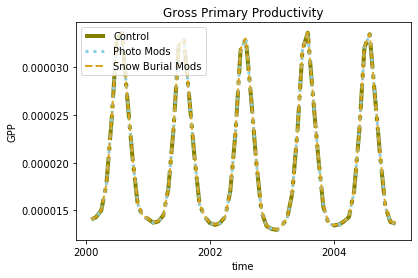

In [3]:
#contGPP.mean(dim=["time"]).plot()
control["GPP"].mean(dim=["lat", "lon"]).plot(color='olive',linestyle='dashdot',linewidth=4)
photo["GPP"].mean(dim=["lat", "lon"]).plot(color='skyblue',linestyle='dotted',linewidth=3)
snow["GPP"].mean(dim=["lat", "lon"]).plot(color='goldenrod',linestyle='dashed',linewidth=2)
plt.legend(["Control", "Photo Mods", "Snow Burial Mods"],loc=2)
plt.title('Gross Primary Productivity')

Text(0.5, 1.0, 'Exposed Leaf Area Index')

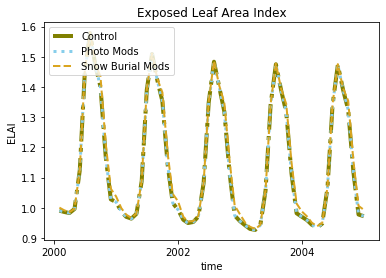

In [4]:
control["ELAI"].mean(dim=["lat", "lon"]).plot(color='olive',linestyle='dashdot',linewidth=4)
photo["ELAI"].mean(dim=["lat", "lon"]).plot(color='skyblue',linestyle='dotted',linewidth=3)
snow["ELAI"].mean(dim=["lat", "lon"]).plot(color='goldenrod',linestyle='dashed',linewidth=2)
plt.legend(["Control", "Photo Mods", "Snow Burial Mods"],loc=2)
plt.title('Exposed Leaf Area Index')

Text(0.5, 1.0, 'Albedo')

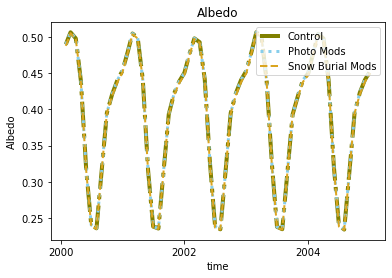

In [5]:
contAlbedo.mean(dim=["lat", "lon"]).plot(color='olive',linestyle='dashdot',linewidth=4)
photoAlbedo.mean(dim=["lat", "lon"]).plot(color='skyblue',linestyle='dotted',linewidth=3)
snowAlbedo.mean(dim=["lat", "lon"]).plot(color='goldenrod',linestyle='dashed',linewidth=2)
plt.legend(["Control", "Photo Mods", "Snow Burial Mods"],loc=1)
plt.ylabel('Albedo')
plt.title('Albedo')

### calculating seasonal means

In [6]:
contSeason = control.groupby("time.season").mean(dim=["time"])
photoSeason = photo.groupby("time.season").mean(dim=["time"])
snowSeason = snow.groupby("time.season").mean(dim=["time"])

contAlbedoSeas = contAlbedo.groupby("time.season").mean(dim=["time"])
photoAlbedoSeas = photoAlbedo.groupby("time.season").mean(dim=["time"])
snowAlbedoSeas = snowAlbedo.groupby("time.season").mean(dim=["time"])

### ordering seasonal means by time rather than alphabetical

In [7]:
contSeason = contSeason.reindex(season=["DJF", "MAM", "JJA", "SON"])
photoSeason = photoSeason.reindex(season=["DJF", "MAM", "JJA", "SON"])
snowSeason = snowSeason.reindex(season=["DJF", "MAM", "JJA", "SON"])

contAlbedoSeas = contAlbedoSeas.reindex(season=["DJF", "MAM", "JJA", "SON"])
photoAlbedoSeas = photoAlbedoSeas.reindex(season=["DJF", "MAM", "JJA", "SON"])
snowAlbedoSeas = snowAlbedoSeas.reindex(season=["DJF", "MAM", "JJA", "SON"])

In [ ]:
#contSeason.FSR.plot(col="season", robust=True)
#photoSeason.FSR.plot(col="season", robust=True)
#snowSeason.FSR.plot(col="season", robust=True)

#### Calculating Differences
##### Photo = Photosynthesis modifications - control
##### Snow = Snow Burial modifications - control

In [8]:
photodiffs = photoSeason - contSeason
snowdiffs  = snowSeason - contSeason

photoalbdiff = photoAlbedoSeas - contAlbedoSeas
snowalbdiff = snowAlbedoSeas - contAlbedoSeas


## Seasonal maps of changes
Identifying seasonal patterns of change

### Albedo Differences
##### Top row: Photo
##### Bottom row: Snow
Differences caused by photo modifications are small.

Differences caused by snow burial are more significant. 
Decreased albedo is most widespread during DJF (expected), but evident throughout all seasons

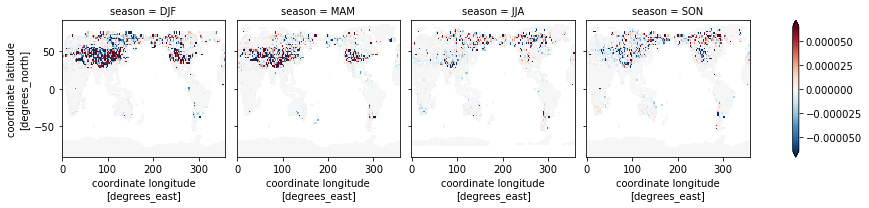

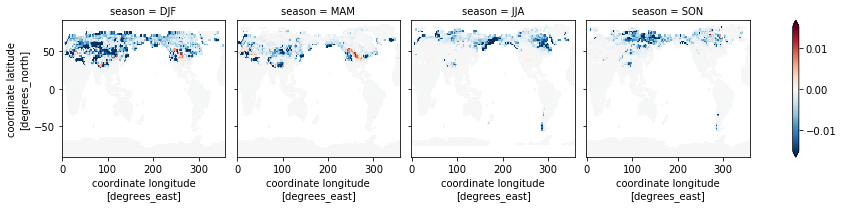

In [9]:
photoalbdiff.plot(col="season", robust=True)
snowalbdiff.plot(col="season", robust=True)

### Snow Depth Differences (m)
##### Top row: Photo
##### Bottom row: Snow

Differences caused by photo modifications are small.

The snow burial bug fix primarily decreases snow depth and is most pronounced during spring (MAM) & summer (JJA)


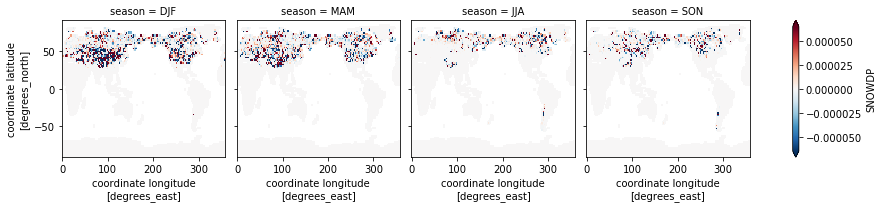

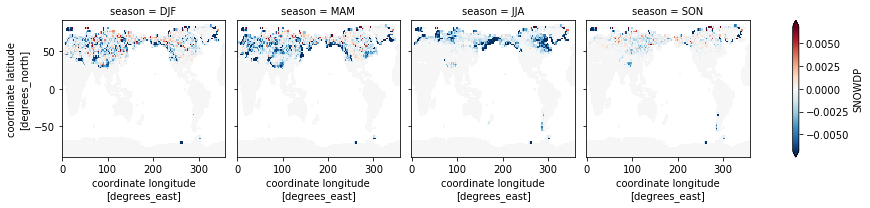

In [10]:
photodiffs.SNOWDP.plot(col="season", robust=True)
snowdiffs.SNOWDP.plot(col="season", robust=True)

### Exposed LAI differences (m^2/m^2)
##### Top row: Photo
##### Bottom row: Snow

Photosynthesis bug fix modifications cause small differences

The snow burial bug fix changes ELAI, with the largest impacts in fall (SON) and winter (DJF).

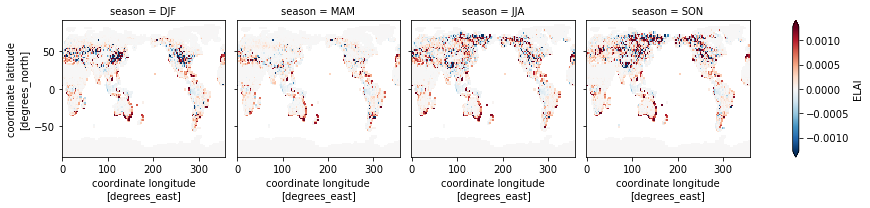

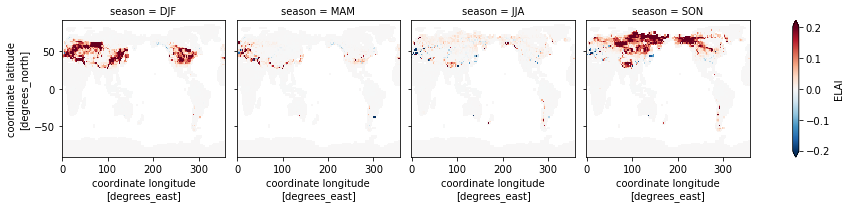

In [11]:
photodiffs.ELAI.plot(col="season", robust=True)
snowdiffs.ELAI.plot(col="season", robust=True)

### GPP differences (gC/m^2/s)
##### Top row: Photo
##### Bottom row: Snow

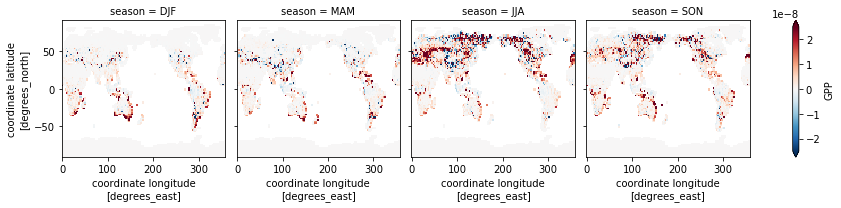

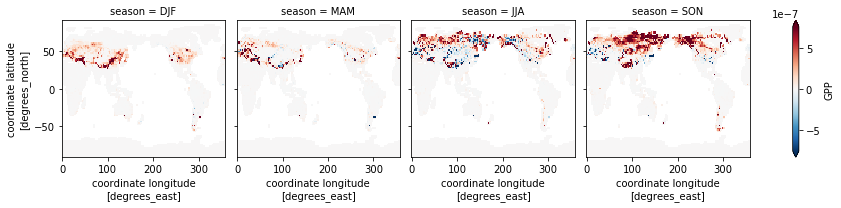

In [12]:
photodiffs.GPP.plot(col="season", robust=True)
snowdiffs.GPP.plot(col="season", robust=True)

### Sensible Heat Flux Differences (W/m^2)
##### Top row: Photo
##### Bottom row: Snow

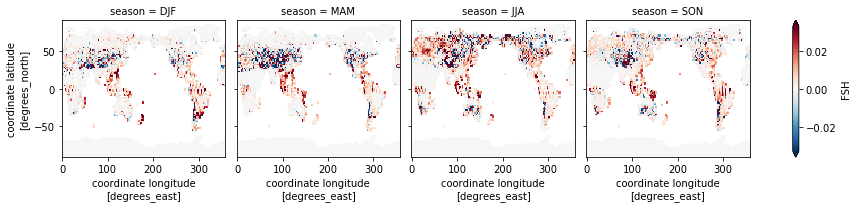

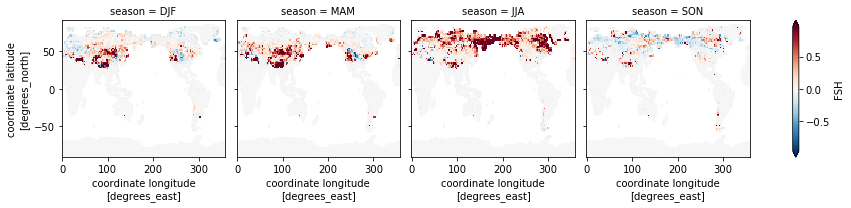

In [13]:
photodiffs.FSH.plot(col="season", robust=True)
snowdiffs.FSH.plot(col="season", robust=True)

### Latent Heat Flux Differences (W/m^2)
##### Top row: Photo
##### Bottom row: Snow
Snow burial modifications generally increase LH flux in all seasons, with some JJA decreases in Central Asia

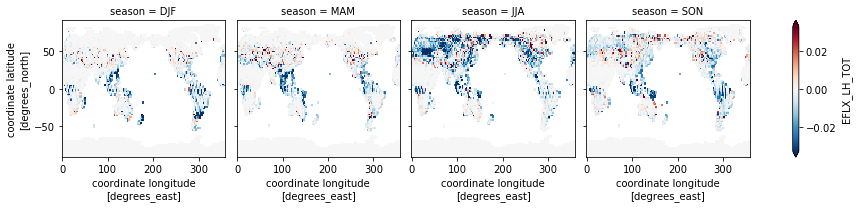

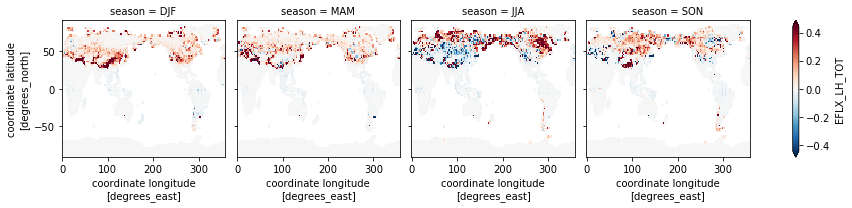

In [14]:
photodiffs.EFLX_LH_TOT.plot(col="season", robust=True)
snowdiffs.EFLX_LH_TOT.plot(col="season", robust=True)

### Runoff Differences (mm/s)
##### Top row: Photo
##### Bottom row: Snow
Changes to snow burial generally increases runoff in MAM and decreases runoff in JJA in high latitudes

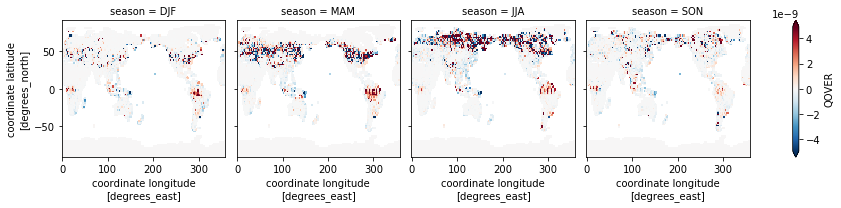

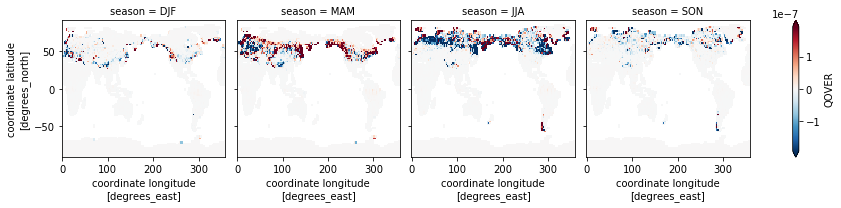

In [15]:
photodiffs.QOVER.plot(col="season", robust=True)
snowdiffs.QOVER.plot(col="season", robust=True)

### Soil Moisture differences
##### Top row: Photo
##### Bottom row: Snow

In [ ]:
#Note: need to deal with soil layers for this to work.
#Might be worth creating a function to weight soil layers
#photodiffs.SOILLIQ.plot(col="season", robust=True)
#snowdiffs.SOILLIQ.plot(col="season", robust=True)